# **Machine Learning using Grammatical Evolution**
### Classification of mammogram segments as containing or not containing suspicious growth. 
Ranya El-Hwigi 18227449

### ***Clone GRAPE repository***

In [1]:
import os.path

In [2]:
PATH = '/users/ranyahwigi/desktop/FYP/grape'
if os.path.exists(PATH):
    print('grape directory already exists')
else:
    !git clone https://github.com/UL-BDS/grape.git 
    print('Cloning grape in your Drive')

%cd /users/ranyahwigi/desktop/FYP/grape/

grape directory already exists
/Users/ranyahwigi/Desktop/FYP/grape


In [3]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

### ***Importing libraries***

In [5]:
!pip install deap
!pip install numpy
!pip install -U imbalanced-learn

import algorithms
from ponyge2_adapted_files import Grammar, ge
from functions import add, sub, mul, pdiv, neg

import numpy as np
from os import path
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from deap import creator, base, tools
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import math

### ***Preparing Data***

**Loading dataset**

In [6]:
# loading in the dataset into a pandas dataframe from GitHub
data = pd.read_csv('https://media.githubusercontent.com/media/relhwigi/GE_GRAPE_Mammogram_Classification/main/data/haralick02_250K.csv')

**Extracting information on the data**

*Size of dataset*

In [7]:
# number of rows in dataset
number_of_samples = data['PatientID'].count()

**Dropping columns from dataset**

In [8]:
data.drop(['PatientID', 'StudyID', 'PatientAge', 'ImgID', 'View', 'SegmentPosition'], axis=1, inplace=True)

**Number of columns remaining**

In [9]:
final_number_of_columns = len(data.columns)

**Train and test split**

In [10]:
X = np.zeros([number_of_samples, final_number_of_columns-1], dtype=float)
Y = np.zeros([number_of_samples,], dtype=int)

for i in range(number_of_samples):
    for j in range(final_number_of_columns-1):
        X[i,j] = data['x'+ str(j)].iloc[i]

for i in range(number_of_samples):
    Y[i] = data['Label'].iloc[i]

oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

print('Training (X,Y):\t', X_train.shape, Y_train.shape)
print('Test (X,Y):\t', X_test.shape, Y_test.shape)

X_train = np.transpose(X_train)
X_test = np.transpose(X_test)

Training (X,Y):	 (33625, 104) (33625,)
Test (X,Y):	 (14411, 104) (14411,)


**Check grammar file**

In [20]:
f = open("../GE_GRAPE_Mammogram_Classification/grammar.bnf", "r")
print(f.read())
f.close() 

<e> ::= add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|

**Setup grammar**

In [21]:
BNF_GRAMMAR = Grammar("../GE_GRAPE_Mammogram_Classification/grammar.bnf")

### ***Fitness Function***

In [22]:
def fitness_eval(individual, points):
  x= points[0]
  Y= points[1]

  if individual.invalid==True:
    return np.NaN,

  try:
    pred= eval(individual.phenotype)
  except (FloatingPointError, ZeroDivisionError, OverflowError, MemoryError):
    return np.NaN,
  assert np.isrealobj(pred)

  try:
    Y_class= [1 if pred[i] > 0 else 0 for i in range(len(Y))]
  except (IndexError, TypeError):
    return np.NaN,

  # TP -> True Positive, FP -> False Posititve, TN -> True Negative, FN -> False Negtaive
  # 0 -> negative, 1 -> positive

  TP, FN, TN, FP = 0, 0, 0, 0

  for x, y in zip(Y, Y_class):
    if x == 1:
      if y == 1:
        TP = TP + 1
      else:
        FN = FN + 1
    elif x == 0:
      if y == 0:
        TN = TN + 1
      else:
        FP = FP + 1

  if FN == 0 and TN == 0:
    return np.NaN,
  elif FP == 0 and TP == 0:
    return np.NaN,
  else:
    # Calculating Accuracy
    numerator = (TP+TN)
    denominator = (TP+TN+FP+FN)
    fitness = numerator / denominator

  return fitness,

### ***Grammatical Evolution***

**Setting GE parameters**

In [23]:
POPULATION_SIZE = 200
MAX_GENERATIONS = 100
P_CROSSOVER = 0.8
P_MUTATION = 0.01
ELITE_SIZE = round(0.01*POPULATION_SIZE)
HALL_OF_FAME_SIZE = 1
MAX_INIT_TREE_DEPTH = 10
MIN_INIT_TREE_DEPTH = 1
MAX_TREE_DEPTH = 17
MAX_WRAPS = 0
CODON_SIZE = 320

**Creating DEAP toolbox**

In [24]:
toolbox = base.Toolbox()

creator.create("FitnessMax", base.Fitness, weights=(1.0,))

creator.create('Individual', ge.Individual, fitness=creator.FitnessMax)

toolbox.register("populationCreator", ge.initialisation_PI_Grow, creator.Individual) 

toolbox.register("evaluate", fitness_eval)

toolbox.register("select", ge.selTournament, tournsize=5)

toolbox.register("mate", ge.crossover_onepoint)

toolbox.register("mutate", ge.mutation_int_flip_per_codon)

**Main function**

In [25]:
population = toolbox.populationCreator(size=POPULATION_SIZE, 
                                        bnf_grammar=BNF_GRAMMAR, 
                                        min_init_tree_depth=MIN_INIT_TREE_DEPTH,
                                        max_init_tree_depth=MAX_INIT_TREE_DEPTH,
                                        max_tree_depth=MAX_TREE_DEPTH, 
                                        max_wraps=MAX_WRAPS,
                                        codon_size=CODON_SIZE
                                        )

hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.nanmean)
stats.register("std", np.nanstd)
stats.register("min", np.nanmin)
stats.register("max", np.nanmax)

population, logbook = algorithms.ge_eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                                        ngen=MAX_GENERATIONS, elite_size=ELITE_SIZE,
                                                        bnf_grammar=BNF_GRAMMAR, codon_size=CODON_SIZE, 
                                                        max_tree_depth=MAX_TREE_DEPTH, max_wraps=MAX_WRAPS,
                                                        points_train=[X_train, Y_train], 
                                                        points_test=[X_test, Y_test], 
                                                        stats=stats, halloffame=hof, verbose=True)

gen	invalid	avg     	std      	min     	max     	fitness_test	best_ind_length	avg_length	max_length	selection_time	generation_time
0  	0      	0.507268	0.0236692	0.429561	0.583346	0.425439    	124            	49.5      	201       	0             	5.93895        
1  	77     	0.504274	0.0218434	0.429561	0.543822	0.545347    	39             	54.06     	220       	0.00119781    	2.66388        
2  	21     	0.509274	0.0220417	0.429561	0.576892	0.578863    	127            	46.97     	176       	0.00114679    	3.45489        
3  	14     	0.515035	0.0186831	0.417309	0.576892	0.578863    	127            	46.51     	177       	0.00114012    	3.44588        
4  	12     	0.515866	0.0193858	0.417309	0.576892	0.578863    	127            	42.745    	191       	0.00119829    	3.5401         
5  	12     	0.517053	0.0218189	0.417309	0.57145 	0.578863    	127            	38.89     	172       	0.00110888    	3.21725        
6  	10     	0.51798 	0.0285803	0.417309	0.579539	0.581847    	48             	43.07

62 	0      	0.551678	0.0592452	0.355361	0.644729	0.6511      	38             	108.81    	252       	0.00111413    	3.81181        
63 	0      	0.540772	0.0641578	0.355361	0.64461 	0.6511      	38             	115.195   	232       	0.00111699    	4.20082        
64 	0      	0.549603	0.0587281	0.355361	0.644639	0.6511      	38             	104.095   	238       	0.00112391    	3.79646        
65 	0      	0.551001	0.0598681	0.355361	0.644669	0.6511      	38             	103.73    	242       	0.00109601    	3.78596        
66 	1      	0.540838	0.0611631	0.355361	0.644669	0.6511      	38             	101.77    	251       	0.00111103    	3.96933        
67 	0      	0.547355	0.0568658	0.355361	0.644669	0.6511      	38             	98.375    	259       	0.00114012    	4.20616        
68 	0      	0.544253	0.066881 	0.355361	0.644669	0.6511      	38             	103.16    	259       	0.00114298    	4.00419        
69 	0      	0.55567 	0.0656273	0.355361	0.646662	0.651724    	209            	110.9

**Statistics**

In [26]:
max_fitness_values, mean_fitness_values = logbook.select("max", "avg")
min_fitness_values, std_fitness_values = logbook.select("min", "std")
fitness_test = logbook.select("fitness_test")
best_ind_length = logbook.select("best_ind_length")
avg_length = logbook.select("avg_length")
max_length = logbook.select("max_length")
selection_time = logbook.select("selection_time")
generation_time = logbook.select("generation_time")
gen, invalid = logbook.select("gen", "invalid")

header = ['gen', 'invalid', 'avg', 'std', 'min', 'max', 'fitness_test', 'best_ind_length', 'avg_length', 'max_length', 'selection_time', 'generation_time']

results = pd.DataFrame(list(zip(gen, invalid, mean_fitness_values, std_fitness_values, min_fitness_values, max_fitness_values, fitness_test, best_ind_length, avg_length, max_length, selection_time, generation_time)),
               columns = header)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)
pd.set_option('display.colheader_justify', 'center')

display(results)

,gen,invalid,avg,std,min,max,fitness_test,best_ind_length,avg_length,max_length,selection_time,generation_time
0,0,0,0.507268,0.023669,0.429561,0.583346,0.425439,124,49.500,201,0.000000,5.938946
1,1,77,0.504274,0.021843,0.429561,0.543822,0.545347,39,54.060,220,0.001198,2.663876
2,2,21,0.509274,0.022042,0.429561,0.576892,0.578863,127,46.970,176,0.001147,3.454887
3,3,14,0.515035,0.018683,0.417309,0.576892,0.578863,127,46.510,177,0.001140,3.445878
4,4,12,0.515866,0.019386,0.417309,0.576892,0.578863,127,42.745,191,0.001198,3.540097
5,5,12,0.517053,0.021819,0.417309,0.571450,0.578863,127,38.890,172,0.001109,3.217252
6,6,10,0.517980,0.028580,0.417309,0.579539,0.581847,48,43.070,172,0.001125,3.416826
7,7,4,0.525798,0.030688,0.417309,0.579569,0.581847,48,41.255,151,0.001095,3.655118
8,8,7,0.531665,0.036076,0.417309,0.579569,0.581847,48,47.125,159,0.001645,3.703326
9,9,3,0.539328,0.037519,0.417309,0.579569,0.581847,48,50.915,160,0.001835,3.938274


**Best individual**

In [27]:
print("Best individual:")
print(hof.items[0].phenotype)
print()
print("Training Fitness: ", hof.items[0].fitness.values[0])
print()
print("Depth: ", hof.items[0].depth)
print()
print("Length of the genome: ", len(hof.items[0].genome))
print()
print(f'Used portion of the genome: {hof.items[0].used_codons/len(hof.items[0].genome):.2f}')
print()

Best individual:
sub(x[33],sub(93.48,x[83]))

Training Fitness:  0.6472862453531598

Depth:  5

Length of the genome:  38

Used portion of the genome: 0.24



Testing best individual

In [11]:
x = X_test

def get_confusion_matrix(Y_labels, Y_predictions):
    TP, FN, TN, FP = 0, 0, 0, 0
    for x, y in zip(Y_labels, Y_predictions):
      if x == 0:
        if y == 0:
          TN = TN + 1
        else:
          FP = FP + 1
      elif x == 1:
        if y == 1:
          TP = TP + 1
        else:
          FN = FN + 1
    return TP, FN, TN, FP

In [12]:
predictions = sub(x[33],sub(93.48,x[83]))
print("Predictions ", predictions)
print()

Y_prediction_class = [1 if predictions[i] > 0 else 0 for i in range(len(predictions))]
print("Labels", Counter(Y_prediction_class))
print()

print("************ Fitness Metrics ************")
print()

TP, FN, TN, FP = get_confusion_matrix(Y_test, Y_prediction_class)
numerator = (TP+TN)
denominator = (TP+TN+FP+FN)
accuracy = numerator / denominator
print("Accuracy:             ", accuracy)
print()

TPR = TP/(TP+FN)
print("True positive rate:   ", TPR)
print()

TNR = TN/(TN+FP)
print("True negative rate:   ", TNR)
print()

FPR = FP/(FP+TN)
print("False positive rate:  ", FPR)
print()

FNR = FN/(FN+TP)
print("False negative rate:  ", FNR)
print()

from sklearn.metrics import roc_auc_score
auc = roc_auc_score(Y_test, Y_prediction_class)
print("Area under the curve: ", auc)

Predictions  [-91.07518143  25.61428022   8.28283386 ...  18.06156828   4.01715273
 -15.23700429]

Labels Counter({1: 10363, 0: 4048})

************ Fitness Metrics ************

Accuracy:              0.6488793282908889

True positive rate:    0.8680083275503123

True negative rate:    0.4297807382736608

False positive rate:   0.5702192617263392

False negative rate:   0.1319916724496877

Area under the curve:  0.6488945329119865


**Best individuals plots**

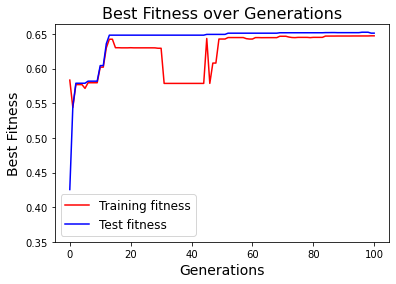

In [42]:
plt.plot(gen, max_fitness_values, color='red', label="Training fitness")
plt.plot(gen, fitness_test, color='blue', label="Test fitness")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Best Fitness', fontsize=14)
plt.title('Best Fitness over Generations', fontsize=16)
plt.yticks(np.arange(0.35, 0.67, 0.05))
plt.show()

**Average fitness plot**

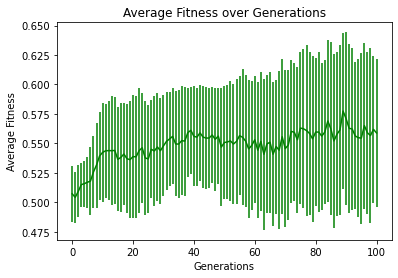

In [43]:
plt.xlabel('Generations')
plt.ylabel('Average Fitness')
plt.title('Average Fitness over Generations')
plt.errorbar(gen, mean_fitness_values, yerr=std_fitness_values,label="Best", color="Green")
plt.show()

**Genome length plots**

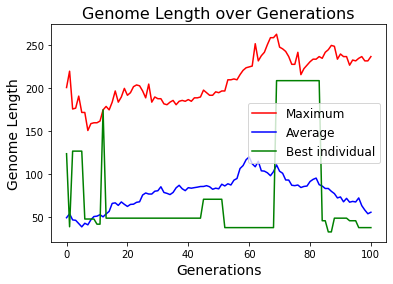

In [44]:
plt.plot(gen, max_length, color='red', label="Maximum")
plt.plot(gen, avg_length, color='blue', label="Average")
plt.plot(gen, best_ind_length, color='green', label="Best individual")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Genome Length', fontsize=14)
plt.title('Genome Length over Generations', fontsize=16)
plt.show()